<a href="https://colab.research.google.com/github/Sharanya-Parimanoharan/AI-Generated-Text-Detection/blob/main/DistilBERT_with_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import string
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Load your dataset (data_2.csv)
df = pd.read_csv("drive/MyDrive/data_2.csv")
#dataset=load_dataset("artem9k/ai-text-detection-pile")
#df=pd.DataFrame(dataset['train'])
print(df.head())

     label                                               text
0  "Human"  The focus of this paper is on a new concept fr...
1     "AI"  This paper centers on introducing a fresh conc...
2  "Human"  Heuristic optimization methods provide a robus...
3     "AI"  This paper introduces a robust and efficient a...
4  "Human"  In this paper the nature of predatory pricing ...


In [ ]:

# Data preprocessing
# Remove punctuation
def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

df['text']= df['text'].apply(remove_punctuation)

# Handle missing values
df.dropna(inplace=True)
df['text'].fillna("NA", inplace=True)

In [ ]:

# Convert labels to integers (assuming 'AI' is positive and others are negative)
df["label_int"] = np.where(df["label"] == '"AI"', 1, 0)


# split train dataset into train, validation and test sets
X_train, temp_text, y_train, temp_labels = train_test_split(df['text'], df['label_int'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label_int'])


X_val, X_test, y_val, y_test = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:

# Load DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

# Tokenize and preprocess the data
max_length = 128  # You can adjust this based on your dataset
batch_size = 32

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Tokenize the training data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_length, return_tensors='pt', add_special_tokens=True)
train_labels = torch.tensor(list(y_train))
train_tokens = tokenizer.convert_ids_to_tokens(train_encodings["input_ids"][0])
print(train_tokens)

# Tokenize the testing data
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length, return_tensors='pt', add_special_tokens=True)
test_labels = torch.tensor(list(y_test))

# Tokenize the val data
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=max_length, return_tensors='pt', add_special_tokens=True)
val_labels = torch.tensor(list(y_val))

# Create DataLoader for training and testing
train_data = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

val_data = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


['[CLS]', '“', 'this', 'paper', 'explores', 'the', 'optimization', 'challenge', 'of', 'designing', 'an', 'underground', 'mine', 'to', 'efficiently', 'manage', 'development', 'and', 'haul', '##age', 'costs', 'with', 'a', 'specific', 'emphasis', 'on', 'the', 'expenses', 'linked', 'to', 'ramps', 'and', 'shafts', 'facilitating', 'movement', 'within', 'ore', 'zones', 'the', 'optimization', 'task', 'is', 'conceptual', '##ized', 'as', 'a', 'weighted', 'network', 'wherein', 'control', 'variables', 'and', 'operational', 'limitations', 'play', 'a', 'crucial', 'role', 'notably', 'mining', 'networks', 'are', 'bound', 'by', 'the', 'constraint', 'that', 'all', 'ramps', 'maintain', 'gradient', '##s', 'within', 'a', 'defined', 'maximum', 'value', 'denoted', 'as', 'm', 'the', 'paper', 'formula', '##tes', 'the', 'mine', 'design', 'dilemma', 'as', 'an', 'optimization', 'quan', '##dar', '##y', 'and', 'establishes', 'that', 'under', 'reasonable', 'conditions', 'the', 'cost', 'function', 'associated', 'with

In [ ]:
# Set up optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10  # You can adjust this based on your dataset


train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Average training loss: {avg_train_loss:.4f}")

    # Validation loop
    model.eval()
    val_total_loss = 0
    for val_batch in val_dataloader:
        val_input_ids, val_attention_mask, val_labels = val_batch
        val_outputs = model(val_input_ids, attention_mask=val_attention_mask, labels=val_labels)
        val_loss = val_outputs.loss
        val_total_loss += val_loss.item()

    avg_val_loss = val_total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Average validation loss: {avg_val_loss:.4f}")




/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/10], Average training loss: 0.6896
Epoch [1/10], Average validation loss: 0.6804
Epoch [2/10], Average training loss: 0.6525
Epoch [2/10], Average validation loss: 0.5866
Epoch [3/10], Average training loss: 0.4583
Epoch [3/10], Average validation loss: 0.2886
Epoch [4/10], Average training loss: 0.2135
Epoch [4/10], Average validation loss: 0.1579
Epoch [5/10], Average training loss: 0.1124
Epoch [5/10], Average validation loss: 0.1226
Epoch [6/10], Average training loss: 0.0608
Epoch [6/10], Average validation loss: 0.1107
Epoch [7/10], Average training loss: 0.0456
Epoch [7/10], Average validation loss: 0.1730
Epoch [8/10], Average training loss: 0.0399
Epoch [8/10], Average validation loss: 0.0880
Epoch [9/10], Average training loss: 0.0343
Epoch [9/10], Average validation loss: 0.1042
Epoch [10/10], Average training loss: 0.0320
Epoch [10/10], Average validation loss: 0.2172


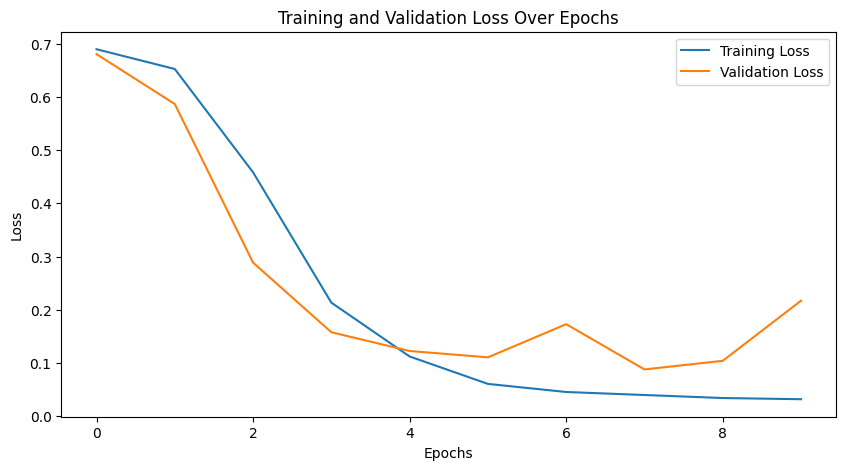

In [ ]:
# plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Input IDs: tensor([[  101,  1523,  2005,  ...,  1998,  2512,   102],
        [  101,  1523,  6145,  ...,  2015,  7605,   102],
        [  101,  1523,  2005,  ...,  1997, 16371,   102],
        ...,
        [  101,  1523,  2023,  ...,  6026,  1996,   102],
        [  101,  1996,  7863,  ...,  2023,  3259,   102],
        [  101,  1996, 19204,  ...,  1037,  2385,   102]])
Logits: tensor([[-2.4759,  2.4711],
        [-2.9058,  2.8666],
        [ 1.4677, -1.5682],
        [-2.7890,  2.7908],
        [-2.9056,  2.7680],
        [-2.9238,  2.8896],
        [-2.8722,  2.7810],
        [ 2.1449, -2.3982],
        [ 2.0260, -2.2684],
        [-2.8569,  2.8652],
        [ 1.3815, -1.6356],
        [-2.5891,  2.5978],
        [-2.8572,  2.8542],
        [-0.4594,  0.5009],
        [-2.2081,  2.2490],
        [ 2.1508, -2.3006],
        [-2.9161,  2.8313],
        [ 2.1596, -2.3880],
        [-2.9320,  2.9027],
        [-2.9118,  2.8432],
        [ 1.4854, -1.5967],
        [ 1.9007, -1.9215],
   

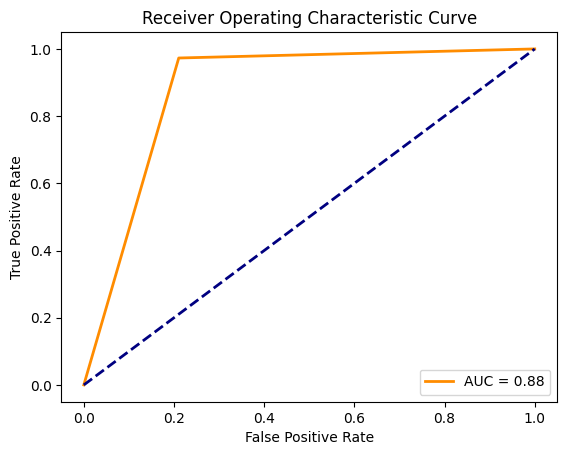

In [ ]:
# Evaluation
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = np.argmax(logits, axis=1).tolist()
        true_label = labels.tolist()

        # Print some batch-wise information
        print("Input IDs:", input_ids)
        print("Logits:", logits)
        print("Predicted Label:", predicted_label)
        print("True Label:", true_label)

        predicted_labels.extend(predicted_label)
        true_labels.extend(true_label)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)


print(true_labels)
print(predicted_labels)
print("Accuracy:", accuracy*100)
print("Classification Report:\n", report)


     # Calculate ROC curve
pr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

    # Calculate AUC
auc_value = roc_auc_score(true_labels, predicted_labels)

       # Plot ROC curve
plt.figure()
plt.plot(pr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save the model
model.save_pretrained("classification_model")
tokenizer.save_pretrained("classification_model/tokenizer")

# Save model to Google Drive
model.save_pretrained("/content/drive/MyDrive/classification_model_withloss")
tokenizer.save_pretrained("/content/drive/MyDrive/classification_model_withloss/tokenizer")

('/content/drive/MyDrive/classification_model_withloss/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/classification_model_withloss/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/classification_model_withloss/tokenizer/vocab.txt',
 '/content/drive/MyDrive/classification_model_withloss/tokenizer/added_tokens.json')

In [ ]:
# Load the test dataset
test_df = pd.read_csv("drive/MyDrive/test_new.csv")

test_df['text'] = test_df['text'].apply(remove_punctuation)

# Convert labels to integers (assuming 'AI' is positive and others are negative)
test_df["label_int"] = np.where(test_df["label"] == '"AI"', 1, 0)


# Split the test dataset into features and labels
X_test = test_df["text"]
y_test = test_df["label_int"]


# Load the pre-trained model and tokenizer
model_name = "/content/drive/MyDrive/classification_model_withloss"
tokenizer_name = "/content/drive/MyDrive/classification_model_withloss/tokenizer"

loaded_model = DistilBertForSequenceClassification.from_pretrained(model_name)
#loaded_tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)

# Tokenize the testing data
max_length = 128  # You can adjust this based on your dataset
batch_size = 12

test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_length, return_tensors='pt', add_special_tokens=True)
test_labels = torch.tensor(list(y_test))

print(len(test_encodings['input_ids']))
print(len(test_encodings['attention_mask']))


# Create DataLoader for testing
test_data = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Evaluation on the test set
loaded_model.eval()
predicted_labels = []
true_labels = []


with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = loaded_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = torch.argmax(logits, dim=1).tolist()
        true_label = labels.tolist()

        predicted_labels.extend(predicted_label)
        true_labels.extend(true_label)

np.savetxt('/content/drive/MyDrive/pred_DistilBERT.csv', predicted_labels, delimiter=',',  fmt='%.2f')


# Calculate metrics on the test set
accuracy = accuracy_score(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels)

report = classification_report(true_labels, predicted_labels)
precision_ai = precision_score(true_labels, predicted_labels, pos_label=1)  # Assuming "AI" is the positive class
precision_human = precision_score(true_labels, predicted_labels, pos_label=0)  # Assuming "AI" is the positive class

recall_ai = recall_score(true_labels, predicted_labels, pos_label=1)  # Assuming "AI" is the positive class
recall_human = recall_score(true_labels, predicted_labels, pos_label=0)  # Assuming "AI" is the positive class

f1_ai = f1_score(true_labels, predicted_labels, pos_label=1)  # Assuming "AI" is the positive class
f1_human = f1_score(true_labels, predicted_labels, pos_label=0)  # Assuming "AI" is the positive class
conf_matrix = confusion_matrix(true_labels, predicted_labels)


print("Accuracy:", accuracy * 100)
print("Classification Report:\n", report)

199
199
Accuracy: 90.95477386934674
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91        97
           1       0.98      0.84      0.91       102

    accuracy                           0.91       199
   macro avg       0.92      0.91      0.91       199
weighted avg       0.92      0.91      0.91       199



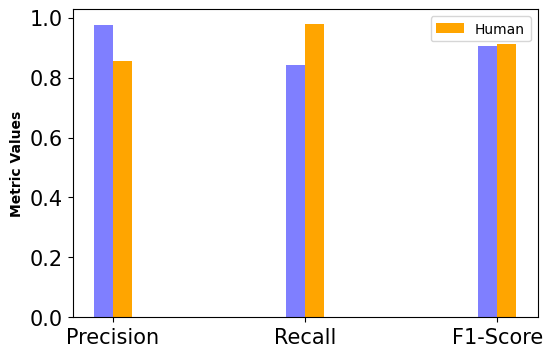

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual values)
ai_values = [precision_ai,recall_ai,f1_ai]
human_values = [precision_human,recall_human,f1_human]

# Metrics names
metrics = [ 'Precision', 'Recall', 'F1-Score']

# Number of metrics
num_metrics = len(metrics)

# Create an array of indices for each metric
indices = np.arange(num_metrics)

# Bar width
bar_width = 0.1

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Plot AI values
ax.bar(indices, ai_values, bar_width,  color='blue',alpha=0.5)

# Plot Human values
ax.bar(indices + bar_width, human_values, bar_width, label='Human', color='orange')

# Customize the plot
ax.tick_params(axis='both', labelsize=15, labelcolor='black')

# Make the axis labels (x and y) bold
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')
ax.set_xticks(indices + bar_width / 2)

ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylabel('Metric Values',fontweight='bold')
#ax.set_title('Comparison of AI and Human Performance Metrics')

# Show the plot
plt.show()

<ipython-input-34-7a7b6b6b604b>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontweight='bold')


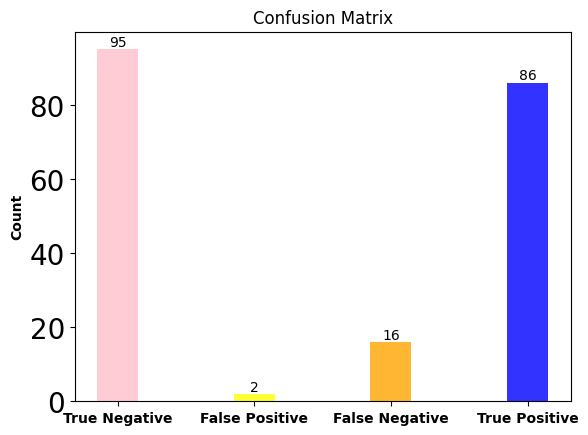

In [ ]:
# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Plotting
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
values = [tn, fp, fn, tp]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['pink', 'yellow', 'orange', 'blue'],alpha=0.8,width=0.3)

# Add labels and title
ax.set_ylabel('Count',fontweight='bold')
ax.set_title('Confusion Matrix')

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.set_xticklabels(labels, fontweight='bold')

ax.tick_params(axis='y', labelsize=20, labelcolor='black')


plt.show()